# LLVIP RGB→IR Pix2Pix + YOLOv8 Fine-tune End-to-End

**What this notebook does (automated flow):**

1. Prepare LLVIP paired lists and dataloaders.
2. Define Pix2Pix Generator & Discriminator.
3. Train Pix2Pix (or run a short demo) and save `checkpoints/G_latest.pt`.
4. Convert VOC annotations to YOLO format and create a `data.yaml` for YOLOv8.
5. Fine-tune `yolov8n.pt` on the IR training images.
6. Inference cell: select an RGB night image, generate pseudo-IR, run YOLO on it, and display results.

**Notes:** Adjust paths, hyperparameters, and epochs before full training. This notebook includes safety checks so it won't accidentally run long training without confirmation.


In [3]:
# 1) Setup: imports, device, paths(""C:\Users\tvipi\Downloads\Final year Project\LLVIP RGB to IR Pix2Pix  YOLOv8 Finetune EndtoEnd\LLVIP_end2end_updated.ipynb"")
import os
from pathlib import Path
import torch
print('torch:', torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device ->', device)


ROOT = Path(r"C:\Users\tvipi\Downloads\Final year Project\LLVIP RGB to IR Pix2Pix  YOLOv8 Finetune EndtoEnd\LLVIP\LLVIP")
assert ROOT.exists(), f'Root path {ROOT} not found. Update ROOT variable to dataset location.'

# Checkpoints and outputs
CKPT_DIR = Path('Final year Project/LLVIP RGB to IR Pix2Pix  YOLOv8 Finetune EndtoEnd/checkpoints'); CKPT_DIR.mkdir(parents=True, exist_ok=True)
YOLO_DIR = Path('Final year Project/LLVIP RGB to IR Pix2Pix  YOLOv8 Finetune EndtoEnd/yolo_finetune'); YOLO_DIR.mkdir(parents=True, exist_ok=True)

print('LLVIP root:', ROOT)
print('Checkpoints dir:', CKPT_DIR)
print('YOLO dir:', YOLO_DIR)


torch: 2.6.0+cu126
device -> cuda
LLVIP root: C:\Users\tvipi\Downloads\Final year Project\LLVIP RGB to IR Pix2Pix  YOLOv8 Finetune EndtoEnd\LLVIP\LLVIP
Checkpoints dir: Final year Project\LLVIP RGB to IR Pix2Pix  YOLOv8 Finetune EndtoEnd\checkpoints
YOLO dir: Final year Project\LLVIP RGB to IR Pix2Pix  YOLOv8 Finetune EndtoEnd\yolo_finetune


In [5]:
# 2) Prepare paired lists and a simple PyTorch Dataset for Pix2Pix
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

vis_train = sorted((ROOT/'visible'/'train').glob('*.*'))
ir_train  = sorted((ROOT/'infrared'/'train').glob('*.*'))

# If lists not found, build pair lists by matching stems in visible train
def build_pairs(split='train'):
    vis = sorted((ROOT/'visible'/split).glob('*.*'))
    ir  = sorted((ROOT/'infrared'/split).glob('*.*'))
    pairs = []
    ir_map = {p.stem: p for p in ir}
    for v in vis:
        if v.stem in ir_map:
            pairs.append((str(v), str(ir_map[v.stem])))
    return pairs

train_pairs = build_pairs('train')
val_pairs   = build_pairs('test')

print(f'Train pairs: {len(train_pairs)}, Val pairs: {len(val_pairs)}')

# Simple Dataset
class PairDataset(Dataset):
    def __init__(self, pairs, size=(256,256)):
        self.pairs = pairs
        self.tf = T.Compose([T.Resize(size), T.ToTensor()])
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        v_path, ir_path = self.pairs[idx]
        v = Image.open(v_path).convert('RGB')
        ir = Image.open(ir_path).convert('L')  # IR grayscale
        v = self.tf(v)
        ir = self.tf(ir)
        return v, ir

# Small sanity loader
train_ds = PairDataset(train_pairs[:200])   # limit for quick run; change as needed
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
print('Sample batch size:', next(iter(train_dl))[0].shape)


Train pairs: 12025, Val pairs: 3463
Sample batch size: torch.Size([4, 3, 256, 256])


In [7]:
# 3) Define Pix2Pix-style Generator (U-Net-ish) and PatchGAN Discriminator (lightweight)
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_c, out_c, ks=4, stride=2, padding=1, batchnorm=True):
    layers = [nn.Conv2d(in_c, out_c, ks, stride, padding, bias=not batchnorm)]
    if batchnorm: layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

def deconv_block(in_c, out_c, ks=4, stride=2, padding=1, dropout=False):
    layers = [nn.ConvTranspose2d(in_c, out_c, ks, stride, padding), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)]
    if dropout: layers.append(nn.Dropout(0.5))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, ngf=64):
        super().__init__()
        # encoder
        self.e1 = conv_block(in_ch, ngf, batchnorm=False)
        self.e2 = conv_block(ngf, ngf*2)
        self.e3 = conv_block(ngf*2, ngf*4)
        self.e4 = conv_block(ngf*4, ngf*8)
        # decoder
        self.d1 = deconv_block(ngf*8, ngf*4, dropout=True)
        self.d2 = deconv_block(ngf*8, ngf*2, dropout=True)
        self.d3 = deconv_block(ngf*4, ngf)
        self.d4 = nn.ConvTranspose2d(ngf*2, out_ch, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        d1 = self.d1(e4)
        d1 = torch.cat([d1, e3], dim=1)
        d2 = self.d2(d1)
        d2 = torch.cat([d2, e2], dim=1)
        d3 = self.d3(d2)
        d3 = torch.cat([d3, e1], dim=1)
        out = self.d4(d3)
        out = self.tanh(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, in_ch=4, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            conv_block(in_ch, ndf, batchnorm=False),
            conv_block(ndf, ndf*2),
            conv_block(ndf*2, ndf*4),
            nn.Conv2d(ndf*4, 1, kernel_size=4, stride=1, padding=1)
        )
    def forward(self, a, b):
        # input: concat RGB (a) and IR (b)
        x = torch.cat([a, b], dim=1)
        return self.net(x)


In [9]:
# 4) Training utilities & train function
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import make_grid, save_image

def save_sample(v, ir, fake_ir, path):
    # v: batch of rgb, ir: real ir, fake_ir: generated
    grid = torch.cat([v, ir.repeat(1,3,1,1), fake_ir.repeat(1,3,1,1)], dim=0)
    grid = make_grid(grid, nrow=v.size(0))
    save_image(grid, path)

def train_pix2pix(G, D, train_loader, val_loader=None, epochs=5, lr=2e-4, l1_lambda=100.0, save_every=1):
    G = G.to(device); D = D.to(device)
    optG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    optD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    bce = nn.BCEWithLogitsLoss()
    l1 = nn.L1Loss()

    for epoch in range(1, epochs+1):
        G.train(); D.train()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}')
        for i, (v, ir) in enumerate(pbar):
            v = v.to(device); ir = ir.to(device)
            # real labels
            real_label = torch.ones((v.size(0),1,31,31), device=device)
            fake_label = torch.zeros_like(real_label)

            # Train D
            optD.zero_grad()
            real_out = D(v, ir)
            lossD_real = bce(real_out, real_label)
            with torch.no_grad():
                fake_ir = G(v)
            fake_out = D(v, fake_ir.detach())
            lossD_fake = bce(fake_out, fake_label)
            lossD = (lossD_real + lossD_fake) * 0.5
            lossD.backward()
            optD.step()

            # Train G
            optG.zero_grad()
            fake_ir = G(v)
            pred_fake = D(v, fake_ir)
            adv_loss = bce(pred_fake, real_label)
            l1_loss = l1(fake_ir, ir)
            lossG = adv_loss + l1_lambda * l1_loss
            lossG.backward()
            optG.step()

            if i % 50 == 0:
                pbar.set_postfix({'lossD': float(lossD.item()), 'lossG': float(lossG.item())})

        # Save checkpoints each epoch (or as requested)
        torch.save(G.state_dict(), os.path.join(CKPT_DIR, 'G_latest.pt'))
        torch.save(D.state_dict(), os.path.join(CKPT_DIR, 'D_latest.pt'))
        print(f'Epoch {epoch} saved checkpoints to {CKPT_DIR}')
    print('Training finished. Checkpoints saved.')


In [178]:
# 5) Quick training run (or skip)
run_train = True  # change to True to run a quick demo training
if run_train:
    G = Generator().to(device); D = Discriminator().to(device)
    # Use small subset for quick debugging; change train_dl to full data for real training
    train_pix2pix(G, D, train_dl, epochs=10, save_every=1)
else:
    print('Skipping training. To run, set run_train=True and re-run this cell.')


Epoch 1/10: 100%|█████████████████████████████████████████████| 50/50 [00:09<00:00,  5.49it/s, lossD=0.707, lossG=61.7]


Epoch 1 saved checkpoints to checkpoints


Epoch 2/10: 100%|█████████████████████████████████████████████| 50/50 [00:08<00:00,  5.67it/s, lossD=0.347, lossG=14.2]


Epoch 2 saved checkpoints to checkpoints


Epoch 3/10: 100%|█████████████████████████████████████████████| 50/50 [00:08<00:00,  5.79it/s, lossD=0.146, lossG=11.9]


Epoch 3 saved checkpoints to checkpoints


Epoch 4/10: 100%|█████████████████████████████████████████████| 50/50 [00:08<00:00,  5.69it/s, lossD=0.276, lossG=12.3]


Epoch 4 saved checkpoints to checkpoints


Epoch 5/10: 100%|█████████████████████████████████████████████| 50/50 [00:08<00:00,  5.66it/s, lossD=0.104, lossG=14.2]


Epoch 5 saved checkpoints to checkpoints


Epoch 6/10: 100%|████████████████████████████████████████████| 50/50 [00:08<00:00,  5.66it/s, lossD=0.0349, lossG=13.3]


Epoch 6 saved checkpoints to checkpoints


Epoch 7/10: 100%|█████████████████████████████████████████████| 50/50 [00:09<00:00,  5.30it/s, lossD=0.162, lossG=11.8]


Epoch 7 saved checkpoints to checkpoints


Epoch 8/10: 100%|█████████████████████████████████████████████| 50/50 [00:09<00:00,  5.28it/s, lossD=0.00857, lossG=13]


Epoch 8 saved checkpoints to checkpoints


Epoch 9/10: 100%|███████████████████████████████████████████████| 50/50 [00:09<00:00,  5.39it/s, lossD=0.223, lossG=11]


Epoch 9 saved checkpoints to checkpoints


Epoch 10/10: 100%|█████████████████████████████████████████████| 50/50 [00:08<00:00,  5.67it/s, lossD=0.0471, lossG=13]

Epoch 10 saved checkpoints to checkpoints
Training finished. Checkpoints saved.


In [91]:
# 6) Load trained Generator for inference (requires checkpoints/G_latest.pt)
G = Generator().to(device)
ckpt_path = CKPT_DIR / 'G_latest.pt'
if ckpt_path.exists():
    G.load_state_dict(torch.load(ckpt_path, map_location=device))
    G.eval()
    print('Loaded generator from', ckpt_path)
else:
    print('Generator checkpoint not found at', ckpt_path, '\nRun training cell first or place G_latest.pt there.')


Generator checkpoint not found at checkpoints\G_latest.pt 
Run training cell first or place G_latest.pt there.


In [156]:
# # 7) Convert VOC annotations (Annotations/) to YOLO format for IR images
# # and directly split into train/val folders for Ultralytics

# from xml.etree import ElementTree as ET
# import random, shutil

# # Params
# train_ratio = 0.8  # 80% train / 20% val

# ann_dir = ROOT / 'Annotations'
# img_dir = ROOT / 'infrared' / 'train'
# labels_out = YOLO_DIR / 'labels'
# images_out = YOLO_DIR / 'images'

# # Make folders
# for d in [
#     images_out/'train', images_out/'val',
#     labels_out/'train', labels_out/'val'
# ]:
#     d.mkdir(parents=True, exist_ok=True)

# # Collect class names
# classes = set()
# for xml_path in sorted(ann_dir.glob('*.xml')):
#     tree = ET.parse(xml_path)
#     for obj in tree.findall('.//object'):
#         cls = obj.findtext('name')
#         classes.add(cls)
# classes = sorted(list(classes))
# print('Classes found in annotations:', classes)

# cls_to_id = {c:i for i,c in enumerate(classes)}

# # Collect all xml files, shuffle for split
# all_xml = sorted(list(ann_dir.glob('*.xml')))
# random.shuffle(all_xml)
# split = int(train_ratio * len(all_xml))
# train_xmls = all_xml[:split]
# val_xmls = all_xml[split:]

# def convert_and_copy(xml_files, split_name):
#     count = 0
#     for xml_path in xml_files:
#         stem = xml_path.stem
#         ir_path = img_dir / (stem + '.jpg')
#         if not ir_path.exists():
#             ir_path = img_dir / (stem + '.png')
#         if not ir_path.exists():
#             continue

#         # copy image
#         dst_img = images_out/split_name/ir_path.name
#         if not dst_img.exists():
#             shutil.copy(ir_path, dst_img)

#         # parse xml
#         tree = ET.parse(xml_path)
#         size = tree.find('size')
#         w = int(size.findtext('width'))
#         h = int(size.findtext('height'))
#         lines = []
#         for obj in tree.findall('.//object'):
#             name = obj.findtext('name')
#             b = obj.find('bndbox')
#             xmin = int(b.findtext('xmin'))
#             ymin = int(b.findtext('ymin'))
#             xmax = int(b.findtext('xmax'))
#             ymax = int(b.findtext('ymax'))
#             # YOLO format
#             x_center = ((xmin + xmax) / 2.0) / w
#             y_center = ((ymin + ymax) / 2.0) / h
#             box_w = (xmax - xmin) / w
#             box_h = (ymax - ymin) / h
#             lines.append(f"{cls_to_id[name]} {x_center} {y_center} {box_w} {box_h}\n")

#         # write label file
#         with open(labels_out/split_name/(dst_img.stem + '.txt'), 'w') as f:
#             f.writelines(lines)
#         count += 1
#     print(f"Converted {count} images for {split_name}")

# convert_and_copy(train_xmls, 'train')
# convert_and_copy(val_xmls, 'val')

# # Write data.yaml
# data_yaml = YOLO_DIR / 'data.yaml'
# content = {
#     'path': str(YOLO_DIR),
#     'train': 'images/train',
#     'val': 'images/val',
#     'names': {i: c for i, c in enumerate(classes)}
# }
# import yaml
# with open(data_yaml, 'w') as f:
#     yaml.dump(content, f)
# print('Wrote', data_yaml)


In [ ]:
# 8) Fine-tune YOLOv8 on IR images (optional - requires ultralytics installed && GPU recommended)
YOLO_DIR = Path('yolo_finetune'); YOLO_DIR.mkdir(parents=True, exist_ok=True)
run_yolo_finetune = True  # Set True to run training
if run_yolo_finetune:
    from ultralytics import YOLO
    
    # Load pretrained YOLOv8n
    model = YOLO('yolov8n.pt')
    
    # Path to data.yaml created in step 7
    data_yaml = str(YOLO_DIR / 'data.yaml')
    print("Using data.yaml at:", data_yaml)
    
    # Train - adjust epochs for real training
    model.train(
        data=data_yaml,
        epochs=100,
        imgsz=640,
        batch=8,
        project=str(YOLO_DIR),
        name='llvip_ir_finetune'
    )
    print('YOLO fine-tuning started (check ultralytics logs).')
else:
    print('Skipping YOLO fine-tuning. Set run_yolo_finetune=True to enable.')


100%|█████████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 12.7MB/s]

Using data.yaml at: yolo_finetune\data.yaml
Ultralytics 8.3.107  Python-3.10.16 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)


engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_finetune\data.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolo_finetune, name=llvip_ir_finetune, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False

100%|█████████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:00<00:00, 39.1MB/s]


AMP: checks passed 


train: Scanning C:\Users\tvipi\Downloads\yolo_finetune\labels\train.cache... 9594 images, 1 backgrounds, 0 corrupt: 100
val: Scanning C:\Users\tvipi\Downloads\yolo_finetune\labels\val.cache... 2431 images, 1 backgrounds, 0 corrupt: 100%|██


Plotting labels to yolo_finetune\llvip_ir_finetune\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_finetune\llvip_ir_finetune
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       1.1G      1.474      1.459      1.216         16        640: 100%|██████████| 1200/1200 [04:15<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:


                   all       2431       6876      0.915      0.869      0.933      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.13G       1.43      0.992      1.199          6        640: 100%|██████████| 1200/1200 [03:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:


                   all       2431       6876      0.918      0.877      0.933      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.13G      1.452     0.9323      1.226         18        640: 100%|██████████| 1200/1200 [03:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.911       0.87      0.934      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.14G      1.464     0.9013      1.242          6        640: 100%|██████████| 1200/1200 [03:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.921      0.891       0.95      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.15G      1.423      0.836      1.227          5        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.928      0.896      0.951      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.15G       1.41     0.8002      1.215          5        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.925      0.895      0.953      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.15G      1.389     0.7789      1.204         10        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.926      0.882      0.947      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.15G      1.372     0.7582      1.194          8        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.933      0.907      0.957      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.15G      1.358     0.7385      1.189          7        640: 100%|██████████| 1200/1200 [03:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.944      0.909       0.96        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.15G      1.344     0.7213      1.179          8        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.941      0.917      0.964      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.15G      1.334     0.7097      1.175          5        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.938      0.916      0.963      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.15G      1.334      0.698      1.177          7        640: 100%|██████████| 1200/1200 [03:48<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.932      0.927      0.966      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.15G      1.321     0.6938      1.168          8        640: 100%|██████████| 1200/1200 [03:48<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.942      0.927      0.969      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.15G      1.311     0.6843      1.163         12        640: 100%|██████████| 1200/1200 [03:47<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.946      0.933       0.97      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.15G      1.304     0.6731      1.159         11        640: 100%|██████████| 1200/1200 [03:47<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.935      0.932      0.969       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.15G       1.31     0.6726      1.158         18        640: 100%|██████████| 1200/1200 [03:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.944      0.928      0.971      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.15G      1.297     0.6645      1.155          7        640: 100%|██████████| 1200/1200 [03:48<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.949      0.931      0.972      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.15G      1.289     0.6589      1.148          7        640: 100%|██████████| 1200/1200 [03:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.943      0.929      0.972      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.15G      1.297     0.6574      1.153          7        640: 100%|██████████| 1200/1200 [03:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.942      0.931      0.972      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.15G       1.28     0.6502      1.143         12        640: 100%|██████████| 1200/1200 [03:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.944      0.931      0.973      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.15G      1.279     0.6453      1.149         17        640: 100%|██████████| 1200/1200 [03:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.947      0.929      0.972      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.15G      1.265     0.6396      1.137          6        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.946      0.936      0.975      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.15G      1.267     0.6359      1.139          8        640: 100%|██████████| 1200/1200 [03:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.948      0.932      0.973      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.16G       1.26     0.6333      1.129          6        640: 100%|██████████| 1200/1200 [03:47<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.945      0.938      0.975      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.16G      1.269     0.6305      1.138          6        640: 100%|██████████| 1200/1200 [03:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.946      0.939      0.976      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.16G      1.254     0.6258       1.13         13        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.944      0.939      0.976      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.16G      1.247     0.6194      1.125          4        640: 100%|██████████| 1200/1200 [03:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.953      0.936      0.977      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.16G      1.252     0.6181      1.128         18        640: 100%|██████████| 1200/1200 [03:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.949       0.94      0.975      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.16G      1.241     0.6131      1.125          8        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.946      0.938      0.976      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.16G      1.238     0.6136      1.118          9        640: 100%|██████████| 1200/1200 [03:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.946       0.94      0.977      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.16G      1.233     0.6064      1.119         18        640: 100%|██████████| 1200/1200 [03:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.955      0.936       0.98      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.16G      1.234     0.6059      1.121         11        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.943      0.943      0.977      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.16G      1.234     0.6035       1.12          4        640: 100%|██████████| 1200/1200 [03:43<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.946      0.942      0.978      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.16G      1.229     0.6029      1.118          9        640: 100%|██████████| 1200/1200 [03:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.951      0.939      0.978      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.16G      1.222     0.5965      1.114          9        640: 100%|██████████| 1200/1200 [03:43<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.948      0.942      0.978       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.16G      1.227     0.5931      1.114          8        640: 100%|██████████| 1200/1200 [03:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.952      0.941       0.98       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.16G      1.215     0.5891       1.11          3        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.949      0.944      0.978      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.16G      1.215     0.5893      1.107         10        640: 100%|██████████| 1200/1200 [03:43<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.951      0.941      0.979      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.16G      1.209     0.5855      1.107          6        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876       0.95      0.949       0.98       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.16G      1.212     0.5837      1.107          5        640: 100%|██████████| 1200/1200 [03:42<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.949      0.949       0.98      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.16G      1.204     0.5798      1.104          2        640: 100%|██████████| 1200/1200 [03:43<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.951      0.946      0.979      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.16G      1.205     0.5774      1.102          2        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.948      0.948      0.979      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.16G      1.204     0.5782      1.101          5        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876       0.95      0.946       0.98      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.16G        1.2     0.5738      1.101          6        640: 100%|██████████| 1200/1200 [03:42<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876       0.95       0.95      0.981      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.16G      1.199     0.5726      1.101          9        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.952      0.949      0.981      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.16G      1.193     0.5682      1.099          5        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876       0.95      0.947       0.98      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.16G      1.191     0.5644      1.095         14        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.947      0.949       0.98      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.16G      1.183     0.5604      1.096         22        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.942       0.95      0.979      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.16G      1.191      0.566      1.095          5        640: 100%|██████████| 1200/1200 [03:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.948      0.951      0.981       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.16G      1.184     0.5615      1.092          6        640: 100%|██████████| 1200/1200 [03:39<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.952      0.946       0.98      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.16G      1.178     0.5579      1.087          5        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.954      0.948      0.982      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.16G      1.173     0.5585      1.088         10        640: 100%|██████████| 1200/1200 [03:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.953      0.947      0.981      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.16G      1.173     0.5562      1.087         11        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.949      0.951      0.981      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.16G      1.172     0.5531      1.086         15        640: 100%|██████████| 1200/1200 [03:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.948      0.954      0.982      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.16G      1.173     0.5542      1.085         15        640: 100%|██████████| 1200/1200 [03:39<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876       0.95      0.954      0.981      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.16G      1.171     0.5469      1.083          7        640: 100%|██████████| 1200/1200 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.951      0.951      0.982      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.16G      1.173     0.5486      1.086          6        640: 100%|██████████| 1200/1200 [03:37<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876       0.95      0.953      0.982      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.16G      1.169     0.5466      1.085         13        640: 100%|██████████| 1200/1200 [03:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.955      0.949      0.981      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.16G      1.159      0.542      1.079          6        640: 100%|██████████| 1200/1200 [03:39<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.951       0.95      0.981      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.16G      1.165     0.5442      1.083         12        640: 100%|██████████| 1200/1200 [03:39<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.953      0.947      0.981      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.16G      1.157       0.54      1.077          3        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.957      0.945      0.981      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.16G      1.151     0.5357      1.075          5        640: 100%|██████████| 1200/1200 [03:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876       0.95      0.951      0.981      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.16G      1.155     0.5343      1.078          7        640: 100%|██████████| 1200/1200 [03:45<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.952      0.949      0.981      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.16G       1.15     0.5335      1.077         10        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876       0.95      0.947      0.981      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.16G      1.151     0.5315      1.075          9        640: 100%|██████████| 1200/1200 [03:44<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.951      0.949      0.982      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.16G      1.153     0.5318      1.075          7        640: 100%|██████████| 1200/1200 [03:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.954      0.946      0.982      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.16G      1.139     0.5252      1.072          2        640: 100%|██████████| 1200/1200 [03:39<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.956      0.946      0.982      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.16G      1.137     0.5259      1.068          9        640: 100%|██████████| 1200/1200 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.954      0.948      0.982      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.16G      1.136     0.5213      1.071         10        640: 100%|██████████| 1200/1200 [03:39<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.954      0.947      0.981      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.16G      1.129     0.5206       1.07          8        640: 100%|██████████| 1200/1200 [03:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.957      0.946      0.982       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.16G      1.131     0.5208      1.067          9        640: 100%|██████████| 1200/1200 [03:40<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.956      0.945      0.982       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.16G       1.13     0.5177      1.064         22        640: 100%|██████████| 1200/1200 [03:39<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.953      0.949      0.981       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.16G      1.129     0.5184      1.068         14        640: 100%|██████████| 1200/1200 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.957      0.947      0.982      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.16G      1.128     0.5153      1.064          9        640: 100%|██████████| 1200/1200 [03:39<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.955      0.948      0.982      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.16G      1.118     0.5123       1.06          7        640: 100%|██████████| 1200/1200 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.956      0.949      0.982      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.16G      1.117     0.5121      1.062          6        640: 100%|██████████| 1200/1200 [03:39<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.956      0.949      0.982      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.16G      1.116     0.5068      1.059          3        640: 100%|██████████| 1200/1200 [03:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.957      0.947      0.981      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.16G      1.114     0.5094      1.059          8        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.957      0.944      0.981      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.16G      1.107     0.5029      1.055          5        640: 100%|██████████| 1200/1200 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.955      0.946      0.981      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.16G      1.108     0.5031      1.059         11        640: 100%|██████████| 1200/1200 [03:37<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.956      0.947      0.981      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.16G      1.105     0.5032      1.055         11        640: 100%|██████████| 1200/1200 [03:43<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.954      0.947      0.981      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.16G      1.104     0.5021      1.054          1        640: 100%|██████████| 1200/1200 [03:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.957      0.944      0.981      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.16G      1.106     0.4979      1.055          5        640: 100%|██████████| 1200/1200 [03:59<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.954      0.947      0.982      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.16G      1.097     0.4958      1.053          4        640: 100%|██████████| 1200/1200 [03:48<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.957      0.947      0.982      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.16G      1.101     0.4965      1.056         13        640: 100%|██████████| 1200/1200 [03:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.956      0.947      0.982      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.16G      1.096     0.4958      1.053         13        640: 100%|██████████| 1200/1200 [03:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.957      0.947      0.982      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.16G       1.09     0.4916       1.05          7        640: 100%|██████████| 1200/1200 [03:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.953       0.95      0.982      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.16G      1.087     0.4874      1.049          6        640: 100%|██████████| 1200/1200 [03:41<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.956      0.948      0.982      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.16G      1.093     0.4936      1.048         12        640: 100%|██████████| 1200/1200 [03:37<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.956      0.948      0.982      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.16G       1.08     0.4846      1.044         15        640: 100%|██████████| 1200/1200 [03:55<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:

                   all       2431       6876      0.958      0.945      0.982      0.693


Closing dataloader mosaic


In [ ]:
# !pip install ipywidgets

In [33]:
# Load Generator (RGB -> IR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
G.load_state_dict(torch.load("checkpoints/G_latest.pt", map_location=device))
G.eval()

# Load YOLOv8 model (for IR detection)
from ultralytics import YOLO
yolo_model = YOLO("yolo_finetune/llvip_ir_finetune/weights/best.pt")  # change path if needed


In [137]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET

# Base dataset directory
LLVIP_DIR = "LLVIP\LLVIP"

def show_test_image(img_name: str):
    """
    Show Original RGB, IR, and labeled image (with VOC annotation boxes) 
    for a given test image name (without extension).
    
    Example: show_test_image("010001")
    """
    # Paths
    rgb_path = os.path.join(LLVIP_DIR, "visible", "test", f"{img_name}.jpg")
    ir_path = os.path.join(LLVIP_DIR, "infrared", "test", f"{img_name}.jpg")
    ann_path = os.path.join(LLVIP_DIR, "Annotations", f"{img_name}.xml")

    # Load images
    if not os.path.exists(rgb_path):
        print(f"❌ RGB image not found: {rgb_path}")
        return
    if not os.path.exists(ir_path):
        print(f"❌ IR image not found: {ir_path}")
        return
    if not os.path.exists(ann_path):
        print(f"❌ Annotation not found: {ann_path}")
        return

    rgb_img = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_BGR2RGB)
    ir_img = cv2.cvtColor(cv2.imread(ir_path), cv2.COLOR_BGR2RGB)
    labeled_img = rgb_img.copy()

    # Parse annotation XML
    tree = ET.parse(ann_path)
    root = tree.getroot()
    for obj in root.findall("object"):
        name = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # Draw rectangle + label
        cv2.rectangle(labeled_img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
        cv2.putText(labeled_img, name, (xmin, ymin-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

    # Show results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(rgb_img)
    axes[0].set_title("Original RGB (Visible)")
    axes[0].axis("off")

    axes[1].imshow(ir_img, cmap="gray")
    axes[1].set_title("Original IR")
    axes[1].axis("off")

    axes[2].imshow(labeled_img)
    axes[2].set_title("Ground-truth Labels")
    axes[2].axis("off")

    plt.show()
    return ir_img


In [113]:
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import io
import os

# Upload widget
# uploader = widgets.FileUpload(accept='image/*', multiple=False)
# display(uploader)

uploaded_img = None
uploaded_name = None

def get_uploaded_image(uploader):
    global uploaded_img, uploaded_name
    
    if uploader.value:
        # Handle dict or tuple/list return
        file_info = None
        if isinstance(uploader.value, dict):
            file_info = list(uploader.value.values())[0]
        elif isinstance(uploader.value, (tuple, list)):
            file_info = uploader.value[0]
        
        if file_info:
            # Load image
            uploaded_img = Image.open(io.BytesIO(file_info['content'])).convert("RGB")
            # Extract name without extension
            fname = file_info.get('name', 'uploaded_image')
            uploaded_name = os.path.splitext(fname)[0]
            
            print(f"✅ Uploaded: {fname}  |  Stored as: {uploaded_name}")
            return uploaded_img
    return None


In [49]:
rgb_img = get_uploaded_image(uploader)

✅ Uploaded: 190005.jpg  |  Stored as: 190005


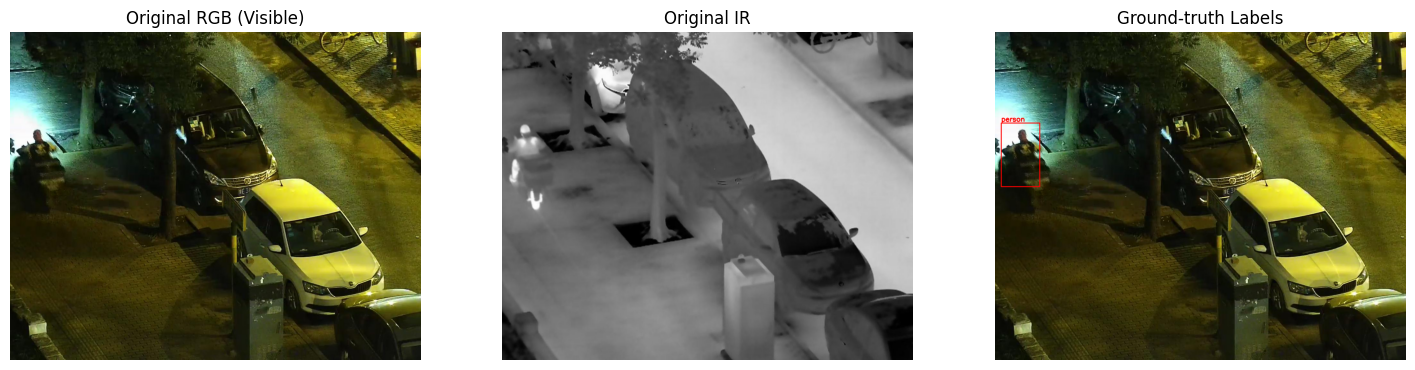

In [51]:
show_test_image(uploaded_name)   # will load visible/test/010001.jpg, infrared/test/010001.jpg, Annotations/010001.xml


In [81]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T

def testing(rgb_img):
    """
    Takes an RGB PIL image, generates fake IR using G,
    and runs YOLO detection on it. Displays results.
    """
    if rgb_img is None:
        print("⚠️ Please upload an image first")
        return
    
    # Convert RGB -> IR using generator
    rgb_tensor = T.ToTensor()(rgb_img).unsqueeze(0).to(device)
    with torch.no_grad():
        fake_ir = G(rgb_tensor).cpu().squeeze(0)
    fake_ir_img = T.ToPILImage()(fake_ir.clamp(0,1))

    # Run YOLO detection on fake IR
    results = yolo_model.predict(fake_ir_img, imgsz=640, verbose=False)

    # Plot outputs
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].imshow(fake_ir_img, cmap="gray")
    t= "Generated IR for -"+uploaded_name
    axes[0].set_title(t )
    axes[0].axis("off")

    annotated = results[0].plot()
    axes[1].imshow(annotated)
    axes[1].set_title("YOLO Detection on IR")
    axes[1].axis("off")

    plt.show()

    return fake_ir_img




In [47]:
# Upload widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

FileUpload(value=(), accept='image/*', description='Upload')

In [167]:
import numpy as np
import torch
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def evaluate_pix2pix(gen_ir, real_ir):
    """Accepts PIL / numpy / torch for both inputs; returns PSNR & SSIM."""
    def to_numpy01(x):
        # -> NumPy, HxW or HxWxC, float32 in [0,1]
        if isinstance(x, torch.Tensor):
            a = x.detach().cpu().numpy()
            # drop batch if present
            if a.ndim == 4 and a.shape[0] == 1:
                a = a[0]
            # channels-first -> channels-last
            if a.ndim == 3 and a.shape[0] in (1, 3, 4):
                a = np.transpose(a, (1, 2, 0))
        elif isinstance(x, Image.Image):
            a = np.array(x)
        elif isinstance(x, np.ndarray):
            a = x
        else:
            raise TypeError(f"Unsupported type: {type(x)}")

        a = a.astype(np.float32)
        if a.max() > 1.0:  # likely uint8 0..255
            a = a / 255.0
        return np.clip(a, 0.0, 1.0)

    def to_gray01(a):
        # -> 2D grayscale float32 in [0,1]
        if a.ndim == 3:
            if a.shape[-1] >= 3:  # RGB/RGBA -> use RGB
                r, g, b = a[..., 0], a[..., 1], a[..., 2]
                a = 0.299 * r + 0.587 * g + 0.114 * b
            else:  # single channel in last dim
                a = a[..., 0]
        return a.astype(np.float32)

    gen = to_numpy01(gen_ir)
    real = to_numpy01(real_ir)

    gen = to_gray01(gen)
    real = to_gray01(real)

    # Ensure same HxW (resize gen to real if needed)
    if gen.shape != real.shape:
        gen_img = Image.fromarray((gen * 255.0).astype(np.uint8))
        gen_img = gen_img.resize((real.shape[1], real.shape[0]), Image.BILINEAR)
        gen = np.array(gen_img).astype(np.float32) / 255.0

    psnr = peak_signal_noise_ratio(real, gen, data_range=1.0)
    ssim = structural_similarity(real, gen, data_range=1.0)  # grayscale -> no channel_axis
    return {"PSNR": float(psnr), "SSIM": float(ssim)}


✅ Uploaded: 190030.jpg  |  Stored as: 190030
Image name: 190030


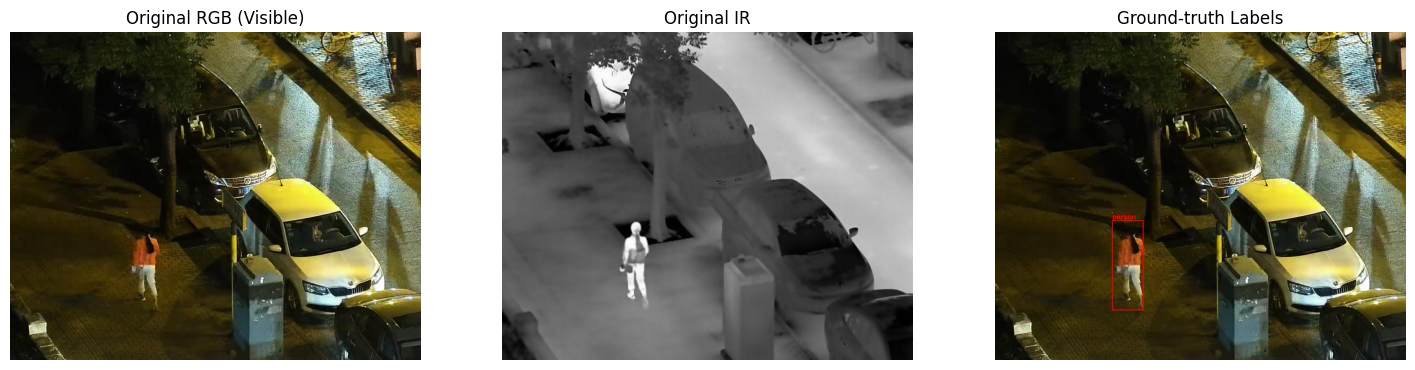

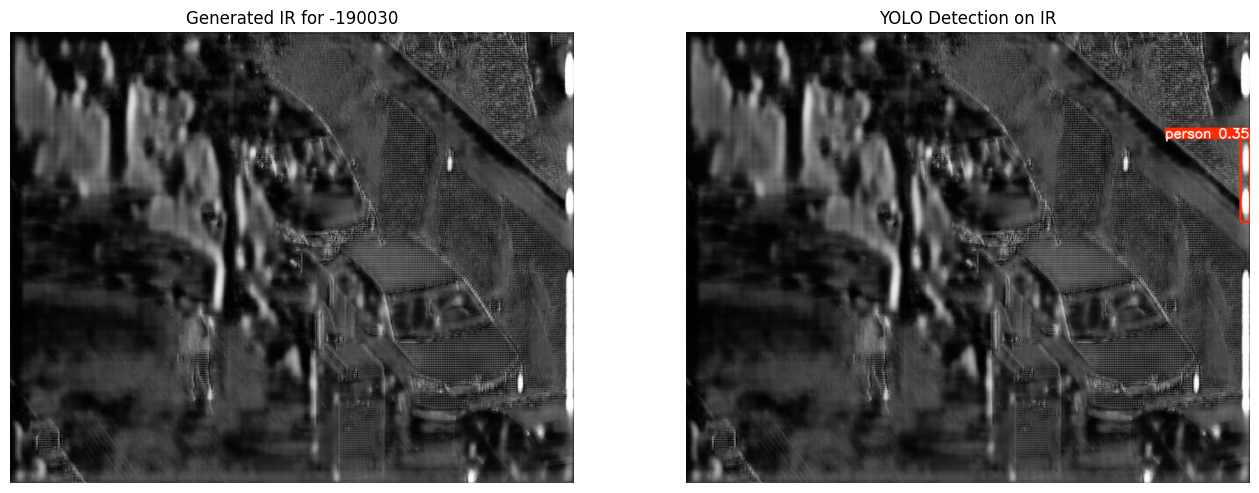

{'PSNR': 10.499384251939679, 'SSIM': 0.2395749925343259}


In [181]:
rgb_img = get_uploaded_image(uploader)
print("Image name:", uploaded_name)
# Get the real IR from dataset (returns NumPy HxWx3)
real_ir = show_test_image(uploaded_name)

# Get the generated IR from Pix2Pix path (returns PIL image)
fake_ir = testing(rgb_img)

# Evaluate
metrics = evaluate_pix2pix(fake_ir, real_ir)
print(metrics)  # {'PSNR': ..., 'SSIM': ...}


In [141]:
T.ToTensor()(fake_ir).shape

torch.Size([1, 1024, 1280])

In [149]:
T.ToTensor()(real_ir).shape

torch.Size([3, 1024, 1280])

In [153]:
# Convert back to tensor
real_ir_tensor = torch.from_numpy(real_ir).unsqueeze(0).float() / 255.0  # shape [1,H,W]


In [155]:
real_ir_tensor.shape

torch.Size([1, 1024, 1280, 3])